### Importing Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib

Setting Global Random seed

In [74]:
np.random.seed(42)

## Loading and preparing Data

In [75]:
df = pd.read_csv("train_genetic_disorders_cleaned.csv")

In [76]:
print(df['genetic_disorder'].value_counts(normalize=True))

genetic_disorder
Mitochondrial genetic inheritance disorders     0.512168
Single-gene inheritance diseases                0.383149
Multifactorial genetic inheritance disorders    0.104682
Name: proportion, dtype: float64


### Feature Engineering

In [77]:
df['genetic_risk'] = (df['maternal_gene_defect'] == 'Yes').astype(int) + (df['paternal_gene_defect'] == 'Yes').astype(int)

In [78]:
df['age_group'] = pd.cut(df['patient_age'], bins=[0, 2, 12, 18], labels=['infant', 'child', 'adolescent'])

In [79]:
def classify_vital_status(resp_rate, heart_rate):
    if resp_rate == "Tachypnea" and heart_rate == "Tachycardia":
        return "Severely Elevated"
    elif resp_rate == "Tachypnea" or heart_rate == "Tachycardia":
        return "Elevated"
    else:
        return "Normal"

df["vital_status"] = df.apply(lambda row: classify_vital_status(row["respiratory_rate"], row["heart_rate"]), axis=1)

In [80]:
def classify_birth_complications(asphyxia, autopsy, defects):
    if asphyxia == "Yes" or autopsy == "Yes" or defects in ["Singular", "Multiple"]:
        return 1
    return 0

df["birth_complications"] = df.apply(lambda row: classify_birth_complications(
    row["birth_asphyxia"], row["birth_defect_autopsy"], row["birth_defects"]), axis=1)

In [81]:
def classify_maternal_risk(illness, radiation, substance):
    if illness == "Yes" or radiation == "Yes" or substance == "Yes":
        return 1
    return 0

df["maternal_risk_factors"] = df.apply(lambda row: classify_maternal_risk(
    row["maternal_illness_history"], row["radiation_exposure_history"], row["substance_abuse_history"]), axis=1)

In [82]:
def classify_pregnancy_history(anomalies, abortions):
    if anomalies == "Yes" or abortions == "Yes":
        return 1
    return 0

df["pregnancy_history"] = df.apply(lambda row: classify_pregnancy_history(
    row["previous_pregnancy_anomalies"], row["previous_abortions"]), axis=1)

In [83]:
col_to_drop = [
    "patient_age",
    "respiratory_rate", "heart_rate",
    "birth_asphyxia", "birth_defect_autopsy", "birth_defects",
    "maternal_illness_history", "radiation_exposure_history", "substance_abuse_history",
    "previous_pregnancy_anomalies", "previous_abortions",
    "maternal_gene_defect", "paternal_gene_defect",
    "maternal_gene", "paternal_gene",
    "birth_place"
]

df = df.drop(columns=col_to_drop)


In [84]:
df.head()

,RBC_count,status,follow_up,gender,folic_acid_supplement,assisted_conception,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass,symptom_total,genetic_risk,age_group,vital_status,birth_complications,maternal_risk_factors,pregnancy_history
0,4.760603,Alive,High,Missing,No,No,9.857562,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,5,1,infant,Normal,1,1,1
1,5.073391,Alive,Low,Male,Yes,Yes,8.605348,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,5,1,child,Elevated,1,1,0
2,5.067562,Deceased,Low,Female,Yes,Yes,3.494528,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,2,child,Elevated,1,1,0
3,5.133352,Deceased,Low,Male,Yes,No,8.614972,normal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,1,child,Elevated,1,1,1
4,4.805143,Alive,High,Female,Yes,No,3.756223,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,2,adolescent,Elevated,1,1,0


In [85]:
numerical_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

## Label Encoding

In [86]:
df.to_csv('unfinal csv.csv',index=False)

In [87]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [39]:
df.head()

,RBC_count,status,follow_up,gender,folic_acid_supplement,assisted_conception,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass,symptom_total,genetic_risk,age_group,vital_status,birth_complications,maternal_risk_factors,pregnancy_history
0,4.760603,0,0,2,0,0,9.857562,3,0,5,5,1,infant,1,1,1,1
1,5.073391,0,1,1,1,1,8.605348,3,0,5,5,1,child,0,1,1,0
2,5.067562,1,1,0,1,1,3.494528,3,0,5,4,2,child,0,1,1,0
3,5.133352,1,1,1,1,0,8.614972,2,0,5,4,1,child,0,1,1,1
4,4.805143,0,0,0,1,0,3.756223,3,0,5,4,2,adolescent,0,1,1,0


## One Hot Encoding

In [40]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = onehot_encoder.fit_transform(df[['age_group']])
encoded_df = pd.DataFrame(encoded_array, columns=onehot_encoder.get_feature_names_out(['age_group']))
df_final = pd.concat([df.drop(columns=['age_group']).reset_index(drop=True), encoded_df], axis=1)

## OverSampling using SMOTE

<Axes: ylabel='count'>

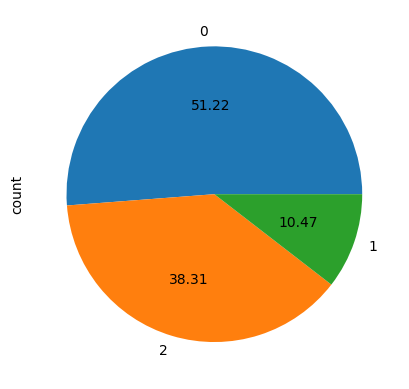

In [42]:
X = df_final.drop(['genetic_disorder','disorder_subclass'], axis=1)
y = df_final['genetic_disorder']
y.value_counts().plot.pie(autopct='%.2f')

<Axes: ylabel='count'>

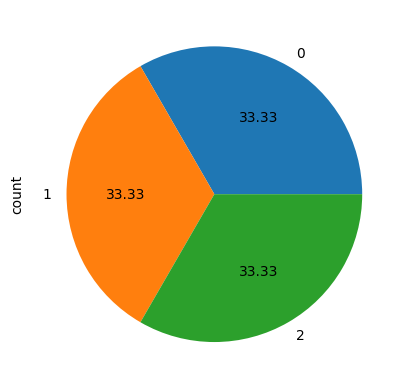

In [43]:
sm = SMOTE(random_state=42)
X_res,y_res = sm.fit_resample(X,y)
y_res.value_counts().plot.pie(autopct='%.2f')

In [44]:
corr_matrix = df_final.corr()
print("Correlation Matrix:\n", corr_matrix)

Correlation Matrix:
                         RBC_count    status  follow_up    gender  \
RBC_count                1.000000 -0.000464  -0.005101 -0.005425   
status                  -0.000464  1.000000  -0.002802  0.005308   
follow_up               -0.005101 -0.002802   1.000000 -0.012661   
gender                  -0.005425  0.005308  -0.012661  1.000000   
folic_acid_supplement   -0.010137  0.002218   0.003819 -0.001138   
assisted_conception      0.003090 -0.002872   0.008010  0.006977   
white_blood_cell_count   0.002606  0.005924  -0.007394  0.001715   
blood_test_result        0.005120  0.007684  -0.005387  0.000299   
genetic_disorder        -0.004629 -0.003753  -0.062627  0.049594   
disorder_subclass        0.006315  0.011998  -0.006224 -0.016088   
symptom_total            0.006752 -0.016546   0.018553  0.018416   
genetic_risk            -0.009693  0.012028   0.000442 -0.002190   
vital_status            -0.000987 -0.003495  -0.000446 -0.009732   
birth_complications        

In [45]:
df_final.to_csv("testing.csv", index =False)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    stratify=y_res,
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 23284
Test samples: 5822


In [47]:
print(X_train.shape,X_test.shape)

(23284, 18) (5822, 18)


## Applying PCA

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
pca = PCA(n_components=18) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [50]:
X_test_pca[0]

array([ 7.33479600e-01, -2.67486314e-01, -2.48086541e-01, -5.37323062e-01,
       -3.56144411e-01,  8.91364667e-01,  3.15836800e-01, -2.19292884e+00,
       -1.08616400e+00,  9.87198869e-01, -8.64930646e-02,  7.34013919e-02,
        4.50694425e-02,  6.12003972e-01,  1.78090486e-01, -2.25020043e+00,
        4.91948016e-17,  1.74888235e-15])

## XGB Model 

In [51]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb_classifier = XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    random_state=42,
    reg_alpha=10,    
    reg_lambda=20,   
)

xgb_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=3, ...)

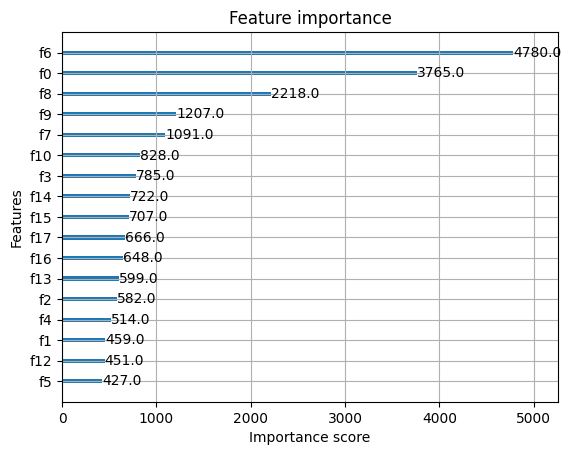

In [52]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_classifier)
plt.show()


In [53]:
y_pred = xgb_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, xgb_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

In [54]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7074
Test Accuracy: 0.6881


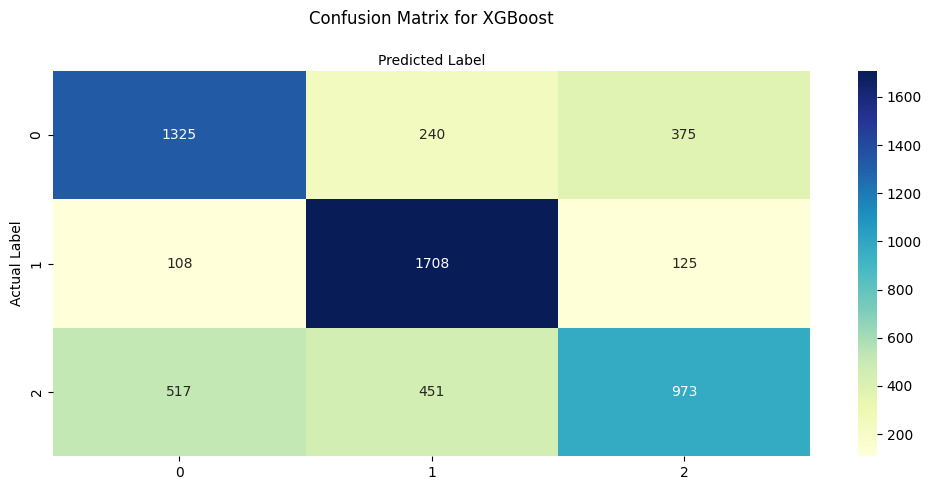

In [55]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')

plt.title(f'Confusion Matrix for XGBoost', y=1.1)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()

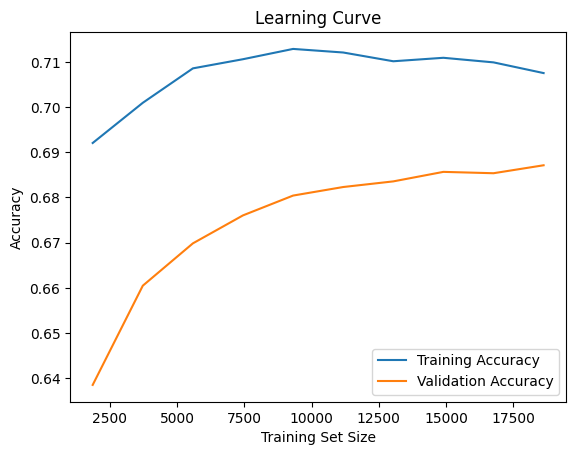

In [56]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    xgb_classifier, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.legend()
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()


# Exporting Model

In [57]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(label_encoder, "label_encoders.pkl")
joblib.dump(onehot_encoder, "one_hot_encoder.pkl")
joblib.dump(xgb_classifier, "xgb_model.pkl")

['xgb_model.pkl']

## Trying Other models

In [58]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(
    solver='lbfgs', 
    max_iter=500, 
    random_state=42
)

In [59]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [60]:
y_pred = log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, log_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

In [61]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.5802
Test Accuracy: 0.5773


In [62]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

In [63]:
svm_classifier.fit(X_train, y_train)

SVC(random_state=42)

In [64]:
y_pred = svm_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, svm_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

In [65]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7144
Test Accuracy: 0.6644


In [66]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,                # Try reducing more
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.5,           # Try reducing features per split
    bootstrap=False,            # Reduce variance by disabling bagging
    random_state=42
)


In [67]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=4, max_features=0.5,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [68]:
y_pred = rf_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, rf_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

In [69]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.6182
Test Accuracy: 0.6183


In [70]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.7).fit(X_train, y_train)
print(f"Ridge Regression-Training set score: {ridge.score(X_train, y_train):.2f}")
print(f"Ridge Regression-Test set score: {ridge.score(X_test, y_test):.2f}")

Ridge Regression-Training set score: 0.01
Ridge Regression-Test set score: 0.01
